# Bayesian concentration from dilution series

This notebook will fit the absorbance measurements made in a dilution series to find what your protein concentration is. It does this with three different error models. In order of robustness to outliers they are: Normal (Least Squares), Laplace (robust regression), StudentT with deg of freedom = 4. You then need to specify the prior parameters prior_mean and prior_sigma which should capture your best guess about the range reasonable concentrations.
$$\begin{align}
slope &\sim \mathcal{N}(prior\_mean,prior\_sigma)\\
intercept &\sim \mathcal{N}(0,0.5)\\
\text{mean} &= dilution*slope+intercept \\
\text{conc }\lvert \text{mean, measurement_error} &\sim \begin{cases} 
   \mathcal{N}(\mu=\text{mean},\text{scale}=\text{measurement_error}) & \text{ Model 1}\\
   Laplace(\text{loc=mean,scale=measurement_error}) & \text{ Model 2}\\
   StudentT(\text{df}=4,\text{loc=mean,scale=measurement_error})  & \text{ Model 3}\\
  \end{cases}
\end{align}
$$

In [1]:
%matplotlib inline
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.infer import EmpiricalMarginal, SVI, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS




# Enter the data
X = dilution factor
Y = nanodrop absorbance reading


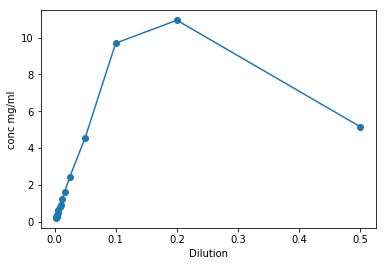

In [2]:

#here are the coefficients for eGFP @ 488 nm
epsilon = 56000. #extinction (per Molar per cm)
mw = 26941.48  #molecular weight (g/mol)


X = 1/np.array([
    2,
    5,
    10,
    20,
    40,
    60,
    80,
    100,
    120,
    160,
    200,
    240,
    260,
    300,
    320,
    360,
    400
])

Y = np.array([
    10.71,
    22.76,
    20.17,
    9.45,
    5.06,
    3.38,
    2.54,
    1.92,
    1.68,
    1.28,
    .93,
    .79,
    .68,
    .52,
    .52,
    .56,
    .41
])



Y = Y*mw/epsilon
plt.plot(X,Y,'o-')
plt.xlabel('Dilution')
plt.ylabel('conc mg/ml')
plt.show()

# Enter your prior belief <span style="color:red">This is important to change!!!</span>

In [3]:
# most important to change these
concentration = 100 # actually the slope mean, but 
concentration_sigma = 20 # std deviation around your prior concentration belief

#less important to modify:
measurement_error = .4 # what is the nanodrop error in terms of mg/ml for this measurement

#below seems pretty sensible, change if you'd like
intercept_mean = 0
intercept_sigma = 0.05

## Defining the models + some handy functions

In [8]:
def model1(dilution):
    """
    Normal Distribution (least squares)
    """
    slope = pyro.sample('slope',dist.Normal(concentration,concentration_sigma))
    intercept = pyro.sample('intercept',dist.Normal(intercept_mean,intercept_sigma))
    mean = slope*dilution+intercept
    with pyro.plate('data',len(dilution)):
        conc = pyro.sample('conc',dist.Normal(mean,measurement_error))
    return conc
def model2(dilution):
    """
    Laplace Distribution (robust regression)
    """
    slope = pyro.sample('slope',dist.Normal(concentration,concentration_sigma))
    intercept = pyro.sample('intercept',dist.Normal(intercept_mean,intercept_sigma))
    mean = slope*dilution+intercept
    with pyro.plate('data',len(dilution)):
        conc = pyro.sample('conc',dist.Laplace(mean,measurement_error))
    return conc

def model3(dilution):
    """
    StudentT Distribution (unamed?)
    """
    slope = pyro.sample('slope',dist.Normal(concentration,concentration_sigma))
    intercept = pyro.sample('intercept',dist.Normal(intercept_mean,intercept_sigma))
    mean = slope*dilution+intercept
    with pyro.plate('data',len(dilution)):
        return pyro.sample('conc',dist.StudentT(df=4,loc=mean,scale=measurement_error))
    
#aforementioned handy functions
def marginal_hist(marginal,label,ax=None,color=None):
    """
    plot the posterior distribution of the concentration given the marginals of slope and intercept
    could get this from the trace predictive by including the point x= 1 in the data
    but i only just realized that ¯\_(ツ)_/¯
    """
    conc = marginal[:,0]+marginal[:,1]
    mean = conc.mean()
    std = conc.std()
    sns.distplot(conc,label='{:}  \t{:.1f} $\pm$ {:.1f} mg/ml'.format(label,mean,std),ax=ax,color=color)
    if ax is None:
        ax=plt.gca()
    ax.set_xlabel('mg/ml')
    ax.set_ylabel('probability')
    return mean,std
def plot_predictive(x,model,posterior,color=None,percentiles=(2.5,97.5),alpha=.25,label=None,ax=None):
    """
    plot the """
    def wrapped_model(x):
        pyro.sample("predictions", dist.Delta(model(x)))
    trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
    post_pred = trace_pred.run(x)
    pred = EmpiricalMarginal(post_pred,['conc'])._get_samples_and_weights()[0].cpu().numpy().squeeze()

    bounds = np.percentile(pred,percentiles,axis=0)
    line = np.median(pred,axis=0)
    if ax is None:
        ax  = plt.gca()
    ax.fill_between(x.numpy(),bounds[0],bounds[1],color=color,alpha=alpha,label=label)
    ax.plot(x.numpy(),line,color=color)


## Torchify data and condition the models

In [9]:
dilution = torch.tensor(X,dtype=torch.float)
measured_conc = torch.tensor(Y,dtype=torch.float)
conditioned_normal = pyro.condition(model1,data={"conc":measured_conc})
conditioned_laplace = pyro.condition(model2,data={"conc":measured_conc})
conditioned_student = pyro.condition(model3,data={"conc":measured_conc})

## Do MCMC to get the posterior concentration

you can change the num_samples or warmup_steps if you'd like. Also you can remove some of the warnings that get thrown if you set `jit_compile=False` but this will make the model slower to run (2x slower on my laptop - IHI)

In [10]:
print('Fitting Model 1')
nuts_normal = NUTS(conditioned_normal, adapt_step_size=True,jit_compile=True)
monte_carlo = MCMC(nuts_normal, num_samples=1000, warmup_steps=200)
hmc_normal_posterior = monte_carlo.run(dilution)

print('Fitting Model 2')

nuts_laplace = NUTS(conditioned_laplace, adapt_step_size=True,jit_compile=True)
monte_carlo = MCMC(nuts_laplace, num_samples=1000, warmup_steps=200)
hmc_laplace_posterior = monte_carlo.run(dilution)

print('Fitting Model 3')

nuts_student = NUTS(conditioned_student, adapt_step_size=True,jit_compile=True)
monte_carlo = MCMC(nuts_student, num_samples=1000, warmup_steps=200)
hmc_student_posterior = monte_carlo.run(dilution)

# get the marginal distributions from the posterior
sites = ['slope','intercept']
marginal_normal = EmpiricalMarginal(hmc_normal_posterior, sites=sites)._get_samples_and_weights()[0].numpy()
marginal_laplace = EmpiricalMarginal(hmc_laplace_posterior, sites=sites)._get_samples_and_weights()[0].numpy()
marginal_student = EmpiricalMarginal(hmc_student_posterior, sites=sites)._get_samples_and_weights()[0].numpy()


Warmup:   0%|          | 0/1200 [00:00<?, ?it/s]

Fitting Model 1


/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  
/home/ianhi/anaconda3/lib/python3.6/site-packages/pyro/poutine/subsample_messenger.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
Warmup:   0%|          | 0/1200 [00:00<?, ?it/s]/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We

Fitting Model 2


Warmup:   0%|          | 0/1200 [00:00<?, ?it/s]/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/home/ianhi/anaconda3/lib/python3.6/site-packages/pyro/poutine/subsample_messenger.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)


Fitting Model 3


Sample: 100%|██████████| 1200/1200 [01:03<00:00, 43.88it/s, step size=6.98e-01, acc. rate=0.957]


## Plot the results

/home/ianhi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


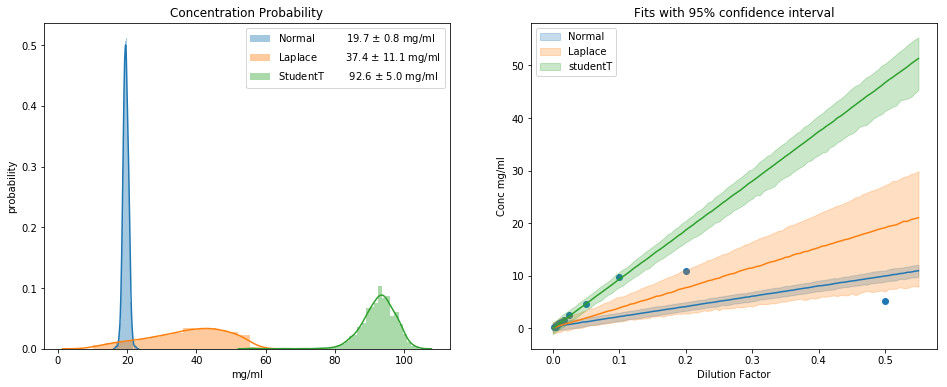

In [7]:
x = torch.linspace(0,X.max()*1.1)
tab = plt.get_cmap('tab10')
fig,ax = plt.subplots(ncols=2,figsize=(16,6))
ax[0].set_title('Concentration Probability')


marginal_hist(marginal_normal,'Normal',ax[0],color=tab(0))
marginal_hist(marginal_laplace,'Laplace',ax[0],color=tab(1))
marginal_hist(marginal_student,'StudentT',ax[0],color=tab(2))
ax[0].legend()
ax[1].scatter(X,Y)
ax[1].set_title('Fits with 95% confidence interval')
plot_predictive(x,model1,hmc_normal_posterior,color=tab(0),label='Normal',ax=ax[1])
plot_predictive(x,model2,hmc_laplace_posterior,color=tab(1),label='Laplace',ax=ax[1])
plot_predictive(x,model3,hmc_student_posterior,color=tab(2),label='studentT',ax=ax[1])
plt.legend()
plt.ylabel('Conc mg/ml')
plt.xlabel('Dilution Factor')
plt.show()